# FraudLens Model Training
This notebook loads Facebook-scraped datasets, preprocesses posts and reviews, and trains a hybrid model using TF-IDF + Isolation Forest.

In [20]:
!pip install seaborn
!pip install sentence-transformers
!pip install altair

### Load JSON files into a combined

In [21]:

import os
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
import joblib

# Define dataset directory
data_dir = Path("..") / "data"
combined_df = []
reviews_corpus = []
print("All JSON files in data/:", list(data_dir.glob("*.json")))
print("path is:", data_dir)

matching_files = list(data_dir.glob("final_scraped_dataset_*.json"))
print("Matching files:", matching_files)

for file in matching_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

            # ✅ Safely load posts
            posts = data.get("Posts", [])
            if isinstance(posts, list) and all(isinstance(p, dict) for p in posts):
                posts_df = pd.DataFrame(posts)
                posts_df["About"] = [data.get("About", "")] * len(posts_df)
                posts_df["Recommendation"] = [data.get("Recommendation", "")] * len(posts_df)
                combined_df.append(posts_df)
            else:
                print(f"⚠️ Skipping file (invalid Posts list): {file.name}")

            # ✅ Collect all review strings
            for r in data.get("Reviews", []):
                if isinstance(r, dict) and r.get("Review"):
                    reviews_corpus.append(r["Review"])

    except Exception as e:
        print(f"❌ Error reading {file.name}: {e}")





df = pd.concat(combined_df, ignore_index=True) if combined_df else pd.DataFrame()
print("✅ Total posts loaded:", len(df))


All JSON files in data/: [WindowsPath('../data/final_scraped_dataset_100065151415346.json'), WindowsPath('../data/final_scraped_dataset_100075925544978.json'), WindowsPath('../data/final_scraped_dataset_100078863471466.json'), WindowsPath('../data/final_scraped_dataset_100079608703063.json'), WindowsPath('../data/final_scraped_dataset_100091660795799.json'), WindowsPath('../data/final_scraped_dataset_100093005317333.json'), WindowsPath('../data/final_scraped_dataset_61551760628634.json'), WindowsPath('../data/final_scraped_dataset_61554401304789.json'), WindowsPath('../data/final_scraped_dataset_61554683844564.json'), WindowsPath('../data/final_scraped_dataset_61558630673177.json'), WindowsPath('../data/final_scraped_dataset_61559671449720.json'), WindowsPath('../data/final_scraped_dataset_apexlaptops.json'), WindowsPath('../data/final_scraped_dataset_BluSpecs.Glasses.json'), WindowsPath('../data/final_scraped_dataset_bookscornerLK.json'), WindowsPath('../data/final_scraped_dataset_Boo

### Preprocess posts (clean text, features)

In [22]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'… see more', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

def preprocess(df):
    df['Cleaned Content'] = df['Post Content'].fillna("").apply(clean_text)
    df['Post Length'] = df['Cleaned Content'].apply(len)
    df['Num Comments'] = df['Comments'].apply(len)
    df['Total Reactions'] = df['Reactions'].apply(lambda x: sum(x.values()) if isinstance(x, dict) else 0)
    df['Angry Ratio'] = df['Reactions'].apply(lambda x: x.get('Angry', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Sad Ratio'] = df['Reactions'].apply(lambda x: x.get('Sad', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Haha Ratio'] = df['Reactions'].apply(lambda x: x.get('Haha', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Love Ratio'] = df['Reactions'].apply(lambda x: x.get('Love', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    return df

if not df.empty:
    df = preprocess(df)
    print("✅ Preprocessing complete.")
    display(display(df))
else:
    print("⚠️ No data to preprocess.")


✅ Preprocessing complete.


Post Content   Comments    Reactions  \
0          https://web.facebook.com/share/18nzCqxRiR/         []           {}   
1          https://web.facebook.com/share/18nzCqxRiR/         []           {}   
2          https://web.facebook.com/share/18nzCqxRiR/         []           {}   
3          https://web.facebook.com/share/18nzCqxRiR/         []           {}   
4                                             No Text         []           {}   
..                                                ...        ...          ...   
631  Hamilton Khaki Field Model : H70455533… See more  [Price ?]           {}   
632            TAG HEUER CARRERACHRONOGRAPH… See more         []  {'Like': 2}   
633             TAG HEUER CARRERApre owned … See more         []  {'Like': 2}   
634                                           No Text         []           {}   
635                                           No Text         []           {}   

                      Timestamp                              About  \
0    2025-04-21T13:41:27.492766  {'Address': 'Colombo, Sri Lanka'}   
1    2025-04-21T13:41:27.498857  {'Address': 'Colombo, Sri Lanka'}   
2    2025-04-21T13:41:27.502851  {'Address': 'Colombo, Sri Lanka'}   
3    2025-04-21T13:41:27.511861  {'Address': 'Colombo, Sri Lanka'}   
4    2025-04-21T13:41:27.515981  {'Address': 'Colombo, Sri Lanka'}   
..                          ...                                ...   
631  2025-04-28T21:47:32.983204  {'Address': 'Colombo, Sri Lanka'}   
632  2025-04-28T21:47:33.004870  {'Address': 'Colombo, Sri Lanka'}   
633  2025-04-28T21:47:33.039407  {'Address': 'Colombo, Sri Lanka'}   
634  2025-04-28T21:47:33.045573  {'Address': 'Colombo, Sri Lanka'}   
635  2025-04-28T21:47:33.050576  {'Address': 'Colombo, Sri Lanka'}   

                   Recommendation                        Cleaned Content  \
0                   not available                                          
1                   not available                                          
2                   not available                                          
3                   not available                                          
4                   not available                                no text   
..                            ...                                    ...   
631  100% recommend (27 reviews)﻿  hamilton khaki field model  h70455533   
632  100% recommend (27 reviews)﻿           tag heuer carrerachronograph   
633  100% recommend (27 reviews)﻿             tag heuer carrerapre owned   
634  100% recommend (27 reviews)﻿                                no text   
635  100% recommend (27 reviews)﻿                                no text   

     Post Length  Num Comments  Total Reactions  Angry Ratio  Sad Ratio  \
0              0             0                0          0.0        0.0   
1              0             0                0          0.0        0.0   
2              0             0                0          0.0        0.0   
3              0             0                0          0.0        0.0   
4              7             0                0          0.0        0.0   
..           ...           ...              ...          ...        ...   
631           37             1                0          0.0        0.0   
632           28             0                2          0.0        0.0   
633           26             0                2          0.0        0.0   
634            7             0                0          0.0        0.0   
635            7             0                0          0.0        0.0   

     Haha Ratio  Love Ratio  
0           0.0         0.0  
1           0.0         0.0  
2           0.0         0.0  
3           0.0         0.0  
4           0.0         0.0  
..          ...         ...  
631         0.0         0.0  
632         0.0         0.0  
633         0.0         0.0  
634         0.0         0.0  
635         0.0         0.0  

[636 rows x 14 columns]

None

### Generate Sentence-BERT embeddings (Fine-tuned) + SBERT Similarity + plot

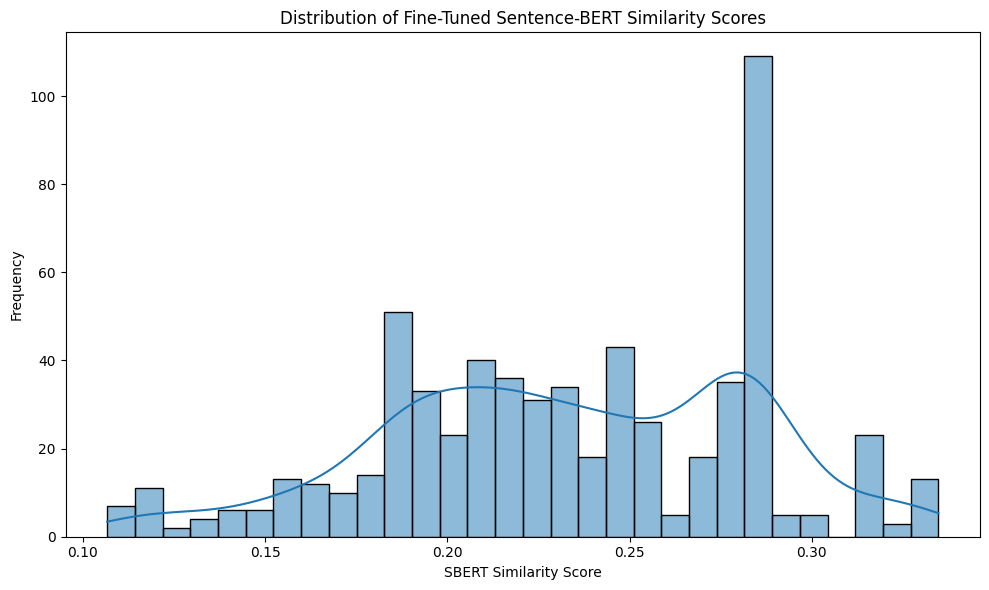

In [23]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

# Load fine-tuned Sentence-BERT model
sbert_model = SentenceTransformer("./fine_tuned_sbert_fraudlens/")

# Encode post content with fine-tuned Sentence-BERT
sbert_embeddings = sbert_model.encode(df['Cleaned Content'].tolist(), convert_to_tensor=True)

# Compute pairwise cosine similarities
cosine_scores = util.pytorch_cos_sim(sbert_embeddings, sbert_embeddings)

# Average similarity for each post
df['SBERT_Similarity'] = cosine_scores.mean(dim=1).cpu().numpy()

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['SBERT_Similarity'], bins=30, kde=True)
plt.title("Distribution of Fine-Tuned Sentence-BERT Similarity Scores")
plt.xlabel("SBERT Similarity Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Fine-tune SBERT model

In [24]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

# Step 1: Load Pretrained Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 2: Prepare Training Examples
examples = [InputExample(texts=[text, text], label=1.0) for text in df['Cleaned Content']]

# Step 3: DataLoader
train_dataloader = DataLoader(examples, shuffle=True, batch_size=16)

# Step 4: Define Loss
train_loss = losses.CosineSimilarityLoss(model)

# Step 5: Fine-Tune
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=10,
    output_path="./fine_tuned_sbert_fraudlens"
)

print("✅ Fine-tuning complete. Model saved at './fine_tuned_sbert_fraudlens'.")

Epoch: 100%|██████████| 1/1 [01:31<00:00, 91.50s/it]


✅ Fine-tuning complete. Model saved at './fine_tuned_sbert_fraudlens'.


### Use fine-tuned SBERT for embeddings + Logistic Regression classifier to predict SBERT_Prob

In [25]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Load fine-tuned Sentence-BERT model
sbert_model = SentenceTransformer("./fine_tuned_sbert_fraudlens/")

# Generate embeddings for post content
sbert_embeddings = sbert_model.encode(df['Cleaned Content'].tolist(), show_progress_bar=True)

# Convert to DataFrame
sbert_df = pd.DataFrame(sbert_embeddings, columns=[f'sbert_{i}' for i in range(sbert_embeddings.shape[1])])

# Merge embeddings into original dataframe
df = pd.concat([df.reset_index(drop=True), sbert_df.reset_index(drop=True)], axis=1)

print("✅ SBERT embeddings generated.")


Batches: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]

✅ SBERT embeddings generated.


### ### Train TF-IDF classifier + Anomaly Detection + Compute FraudLens_Score

In [26]:
# Train TF-IDF + Logistic Regression
tfidf = TfidfVectorizer(max_features=100)
X_reviews = tfidf.fit_transform(reviews_corpus + df['Cleaned Content'].tolist())
dummy_labels = [0] * len(reviews_corpus) + [1] * len(df)
clf_text = LogisticRegression().fit(X_reviews, dummy_labels)

X_text = tfidf.transform(df['Cleaned Content'])
df['Text_Prob'] = clf_text.predict_proba(X_text)[:, 1]

# Anomaly Detection
features = ['Post Length', 'Num Comments', 'Total Reactions', 'Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
X_behavior = df[features].fillna(0)
anomaly_model = IsolationForest(contamination=0.25, random_state=42)
df['Anomaly_Score'] = -anomaly_model.fit(X_behavior).decision_function(X_behavior)

# ⚡️ Train a classifier to predict SBERT_Prob
X_train, X_test, y_train, y_test = train_test_split(sbert_df, np.random.randint(0,2,len(df)), test_size=0.2, random_state=42)

sbert_clf = LogisticRegression(max_iter=1000)
sbert_clf.fit(X_train, y_train)

# Predict probabilities
df['SBERT_Prob'] = sbert_clf.predict_proba(sbert_df)[:, 1]

# Final Score + Export
np.random.seed(42)
df['Trust_Score'] = np.random.uniform(0.5, 1.0, len(df))
df['FraudLens_Score'] = 0.4 * df['SBERT_Prob'] + 0.4 * df['Anomaly_Score'] + 0.2 * (1 - df['Trust_Score'])
df['Fraud_Prediction'] = df['FraudLens_Score'].apply(lambda x: 1 if x > 0.5 else 0)

# Export
df.to_csv("fraudlens_training_output.csv", index=False)
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(sbert_clf, "logistic_model_sbert.pkl")
joblib.dump(anomaly_model, "isolation_model.pkl")
print("✅ Models and results saved.")

print("✅ Training complete. Showing top suspicious posts:")
df[df['Fraud_Prediction'] == 1][['Post Content', 'FraudLens_Score', 'Text_Prob', 'Anomaly_Score']]


C:\Users\hgamage\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


✅ Models and results saved.
✅ Training complete. Showing top suspicious posts:


Empty DataFrame
Columns: [Post Content, FraudLens_Score, Text_Prob, Anomaly_Score]
Index: []

### 📊 FraudLens Score Distribution

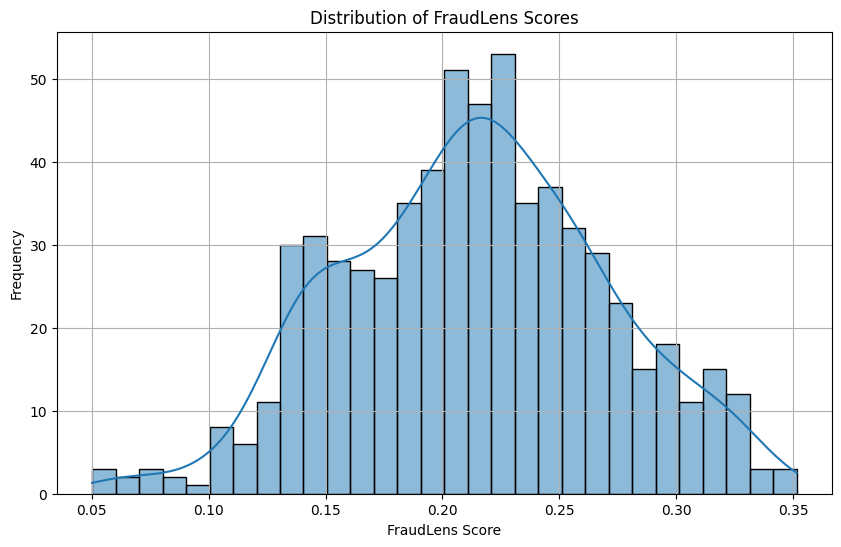

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['FraudLens_Score'], bins=30, kde=True)
plt.title("Distribution of FraudLens Scores")
plt.xlabel("FraudLens Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


###  Blockchain identity simulation future enhancement

In [28]:
# Pseudocode: Blockchain for Identity Verification

class DecentralizedIdentity:
    def __init__(self, user_id):
        self.did = self.generate_did(user_id)
        self.reputation = 100
    
    def generate_did(self, user_id):
        import hashlib
        return hashlib.sha256(user_id.encode()).hexdigest()
    
    def flag_user(self, reason):
        self.reputation -= 10
        self.log_to_blockchain(reason)
    
    def log_to_blockchain(self, reason):
        print(f"📜 Logging: {self.did} flagged for {reason}")

# Example usage
user = DecentralizedIdentity("fraudulent_user@example.com")
user.flag_user("Suspicious posting behavior")


📜 Logging: 054d9406110e202ec1eaa0b551ef1001ffb1374df76c4c37c972f62b2d10c395 flagged for Suspicious posting behavior


### Fraud Prediction Outcome Count

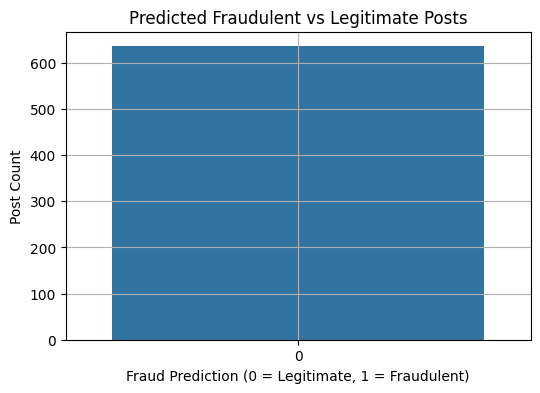

In [39]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Fraud_Prediction", data=df)
plt.title("Predicted Fraudulent vs Legitimate Posts")
plt.xlabel("Fraud Prediction (0 = Legitimate, 1 = Fraudulent)")
plt.ylabel("Post Count")
plt.grid(True)
plt.show()


### Reaction Ratios by Fraud Status

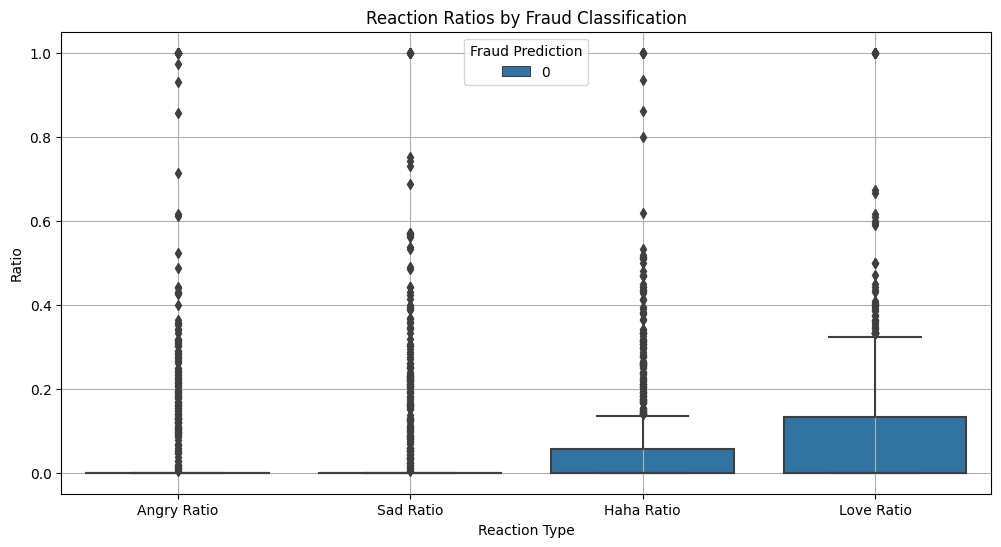

In [30]:
reaction_features = ["Angry Ratio", "Sad Ratio", "Haha Ratio", "Love Ratio"]
melted = df[["Fraud_Prediction"] + reaction_features].melt(id_vars="Fraud_Prediction")

plt.figure(figsize=(12, 6))
sns.boxplot(x="variable", y="value", hue="Fraud_Prediction", data=melted)
plt.title("Reaction Ratios by Fraud Classification")
plt.xlabel("Reaction Type")
plt.ylabel("Ratio")
plt.legend(title="Fraud Prediction")
plt.grid(True)
plt.show()


### Trust Score vs. FraudLens Score Scatter

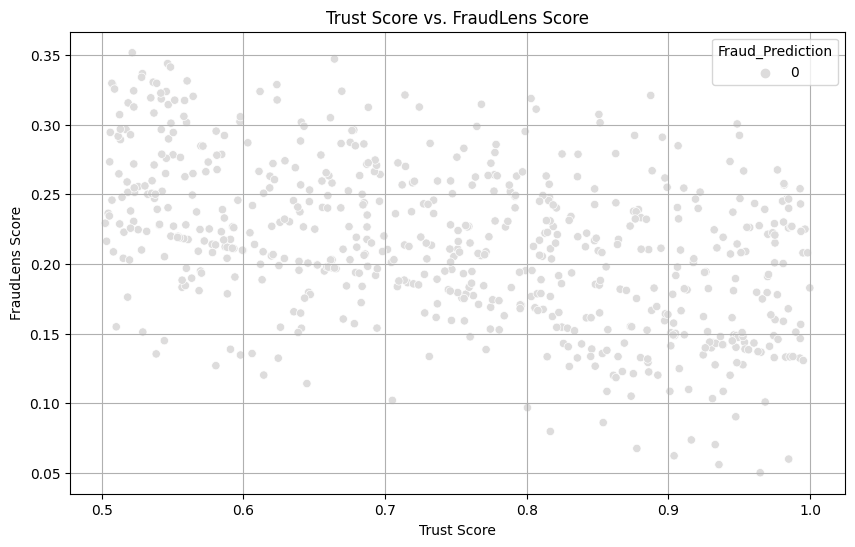

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Trust_Score", y="FraudLens_Score", hue="Fraud_Prediction", palette="coolwarm")
plt.title("Trust Score vs. FraudLens Score")
plt.xlabel("Trust Score")
plt.ylabel("FraudLens Score")
plt.grid(True)
plt.show()


### Temporal Analysis

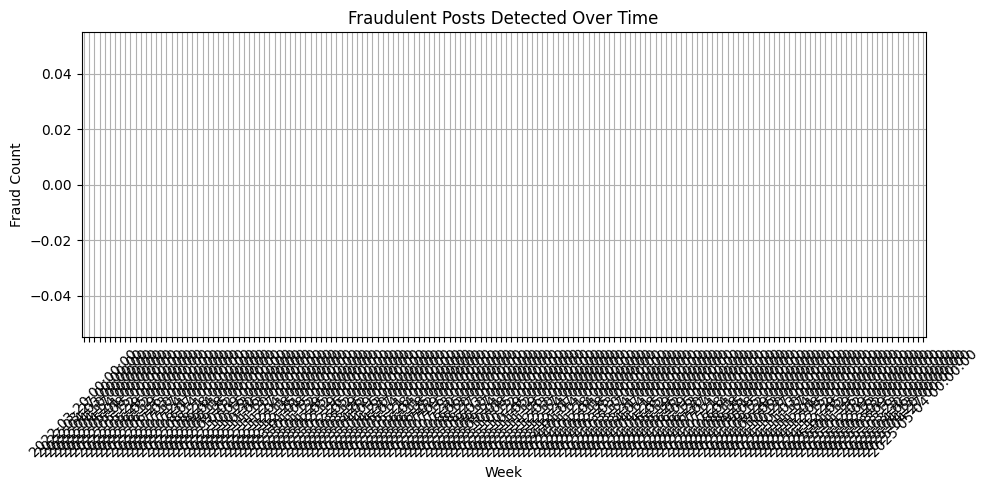

In [32]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')
df.set_index("Timestamp", inplace=True)

fraud_over_time = df.resample("W")["Fraud_Prediction"].sum()

plt.figure(figsize=(10, 5))
fraud_over_time.plot(kind="bar", color="tomato")
plt.title("Fraudulent Posts Detected Over Time")
plt.xlabel("Week")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


### 4.4.1 Distribution of Post Lengths

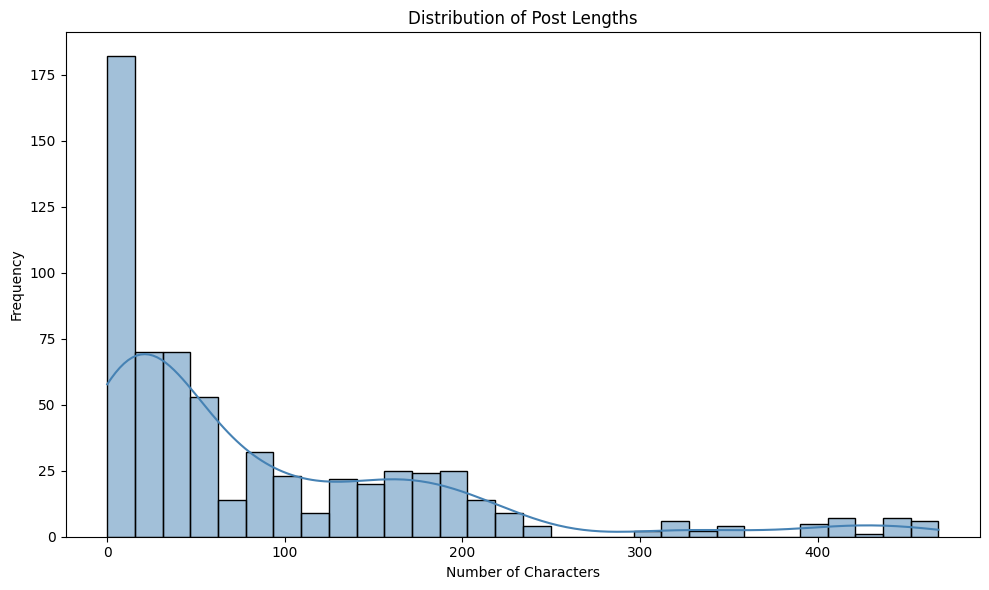

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Post Length'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Post Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 4.4.2 Reaction Ratios by Emotion Type

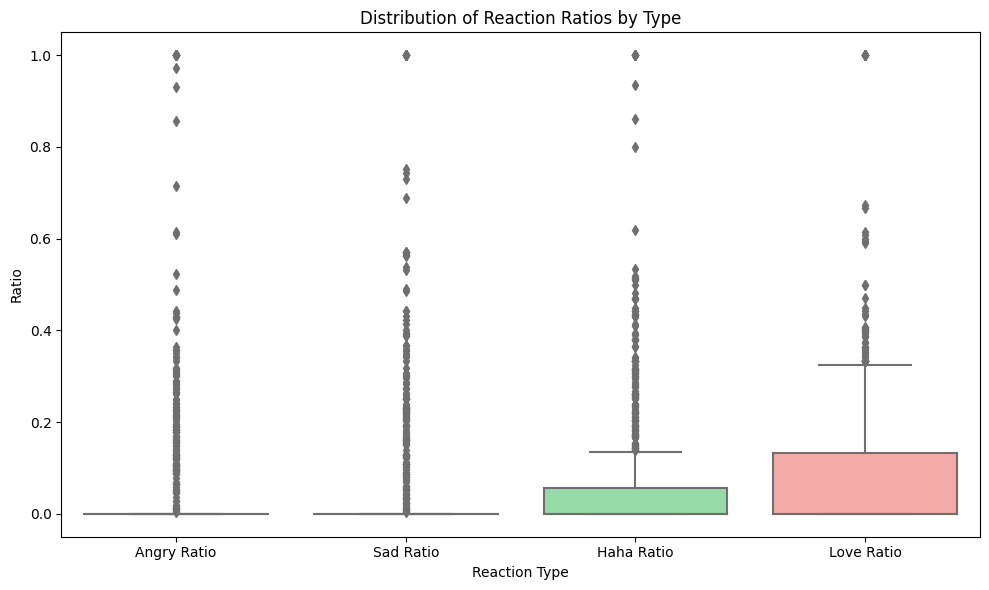

In [34]:
reaction_cols = ['Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
df_melted = df[reaction_cols].melt(var_name='Reaction', value_name='Ratio')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Reaction', y='Ratio', palette='pastel')
plt.title("Distribution of Reaction Ratios by Type")
plt.ylabel("Ratio")
plt.xlabel("Reaction Type")
plt.tight_layout()
plt.show()


### 4.4.3 Comments vs. Reactions

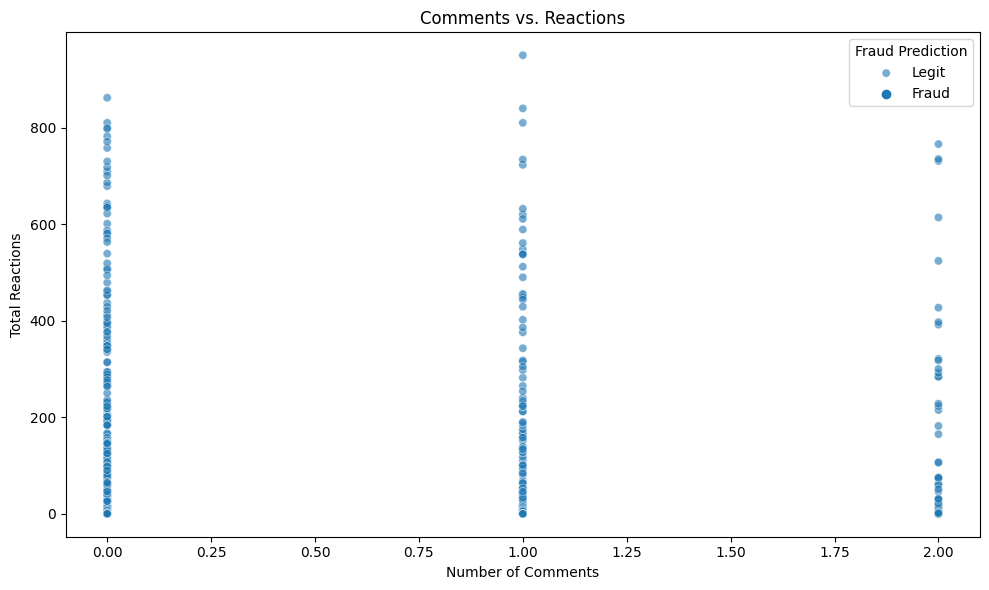

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Num Comments', y='Total Reactions', hue='Fraud_Prediction', alpha=0.6)
plt.title("Comments vs. Reactions")
plt.xlabel("Number of Comments")
plt.ylabel("Total Reactions")
plt.legend(title="Fraud Prediction", labels=["Legit", "Fraud"])
plt.tight_layout()
plt.show()


### 4.4.4 Behavioral Feature Correlation Matrix

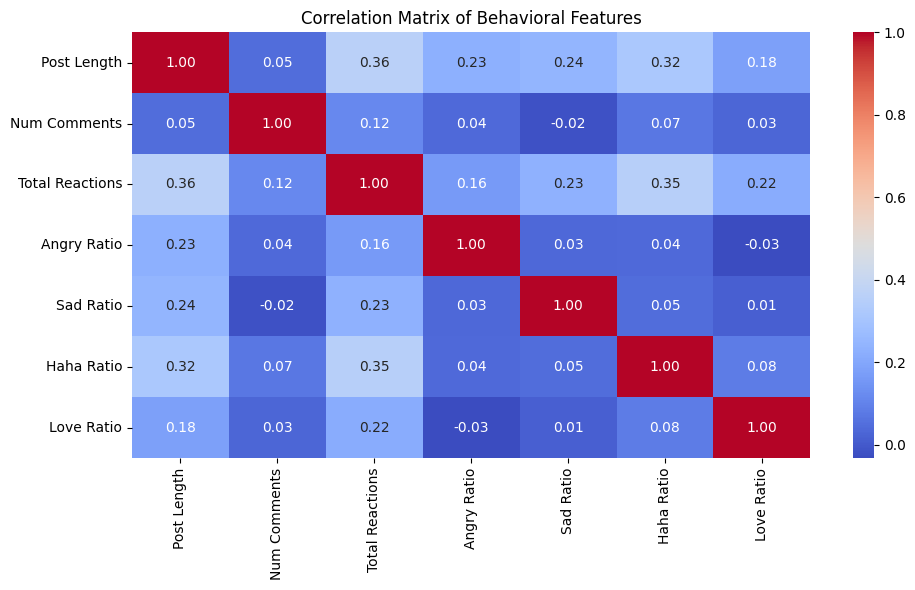

In [36]:
behavior_features = ['Post Length', 'Num Comments', 'Total Reactions', 'Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
plt.figure(figsize=(10, 6))
sns.heatmap(df[behavior_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Behavioral Features")
plt.tight_layout()
plt.show()


### 4.5.1 Trust Score Distribution

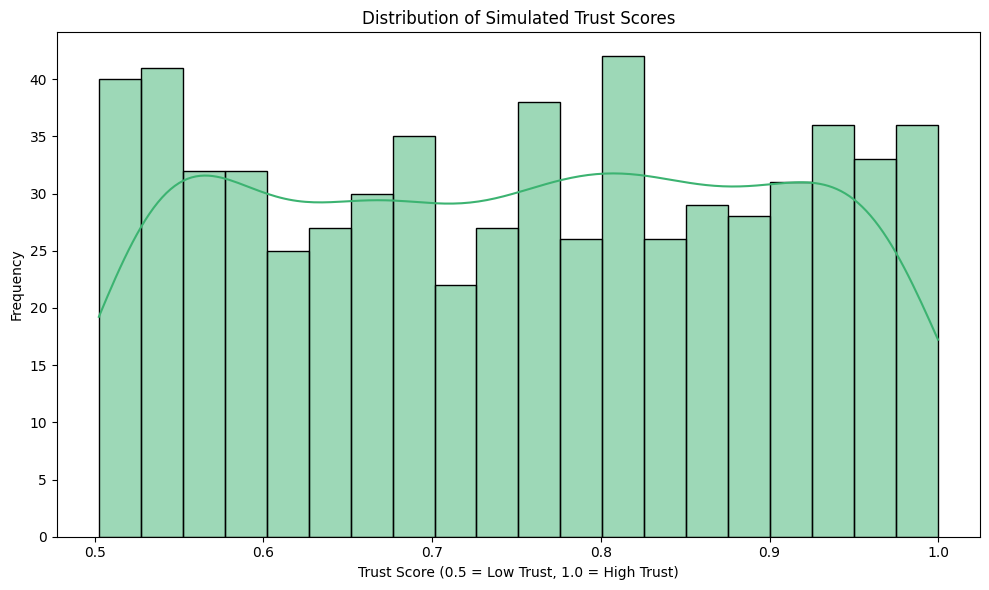

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Trust_Score'], bins=20, kde=True, color='mediumseagreen')
plt.title("Distribution of Simulated Trust Scores")
plt.xlabel("Trust Score (0.5 = Low Trust, 1.0 = High Trust)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 4.5.2 Trust Score vs. FraudLens Score

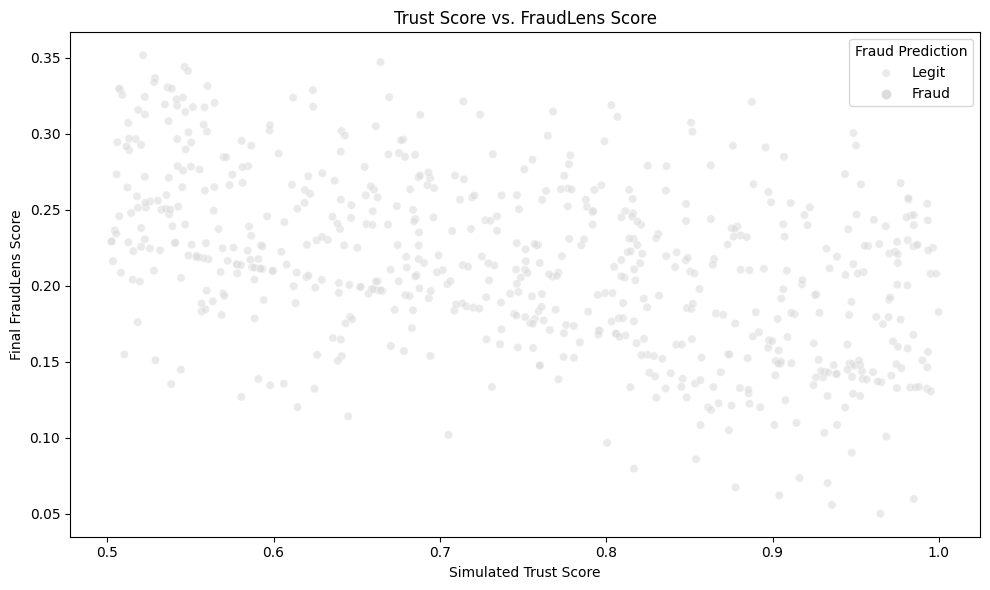

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Trust_Score', y='FraudLens_Score', hue='Fraud_Prediction', alpha=0.6, palette='coolwarm')
plt.title("Trust Score vs. FraudLens Score")
plt.xlabel("Simulated Trust Score")
plt.ylabel("Final FraudLens Score")
plt.legend(title="Fraud Prediction", labels=["Legit", "Fraud"])
plt.tight_layout()
plt.show()
